[INFO] creating woe binning ...
Binning on 142046 rows and 125 columns in 00:01:27
[INFO] converting into woe values ...
Woe transformating on 142046 rows and 124 columns in 00:00:51
[INFO] converting into woe values ...
Woe transformating on 60878 rows and 124 columns in 00:00:21


C:\Users\Faez\anaconda3\lib\site-packages\scorecardpy\scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


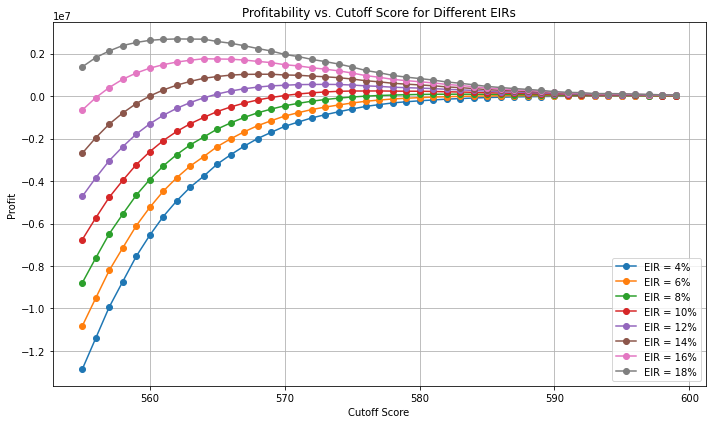

Best cutoff for EIR 4%: 599, Profit = $1,467.96
Best cutoff for EIR 6%: 589, Profit = $18,065.53
Best cutoff for EIR 8%: 583, Profit = $87,143.52
Best cutoff for EIR 10%: 577, Profit = $239,812.05
Best cutoff for EIR 12%: 573, Profit = $549,597.83
Best cutoff for EIR 14%: 569, Profit = $1,026,358.91
Best cutoff for EIR 16%: 564, Profit = $1,755,925.13
Best cutoff for EIR 18%: 562, Profit = $2,688,708.82


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scorecardpy as sc
import random

# Load and preprocess
data = pd.read_csv('merged_dataset.csv')
data = data.replace([np.inf, -np.inf], np.nan)
train, test = sc.split_df(data, y='TARGET', ratio=0.7).values()
train = train.drop(columns=['ORGANIZATION_TYPE'], errors='ignore')
test = test.drop(columns=['ORGANIZATION_TYPE'], errors='ignore')

# WOE transformation
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y='TARGET')
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe.fillna(0, inplace=True)
test_woe.fillna(0, inplace=True)

# Logistic regression
X_train = train_woe.drop(columns='TARGET')
y_train = train_woe['TARGET']
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)

# Scorecard creation
card = sc.scorecard(bins, model, X_train.columns, points0=600, odds0=1/20, pdo=20, basepoints_eq0=True)
flat_card = pd.concat(card.values(), ignore_index=True)
flat_card.to_csv("scorecard_table.csv", index=False)

# Score test data
test_score = sc.scorecard_ply(test, card, only_total_score=True)
test['score'] = test_score['score']

# Function for default probability
def get_default_prob(cutoff, base_odds=20, pdo=20, base_score=600):
    odds_at_cutoff = base_odds / 2 ** ((base_score - cutoff) / pdo)
    return 1 / (1 + odds_at_cutoff)

# Profit calculations
avg_loan_amount = 41000
avg_loss_per_default = 28700
cutoff_scores = np.arange(555, 600, 1)
profits_dict = {}

for eir in range(4, 20, 2):
    profits = []
    for cutoff in cutoff_scores:
        approval_count = test[test["score"] > cutoff].shape[0]
        default_count = get_default_prob(cutoff) * approval_count
        revenue = (approval_count - default_count) * avg_loan_amount * (eir / 100)
        loss = default_count * avg_loss_per_default
        profit = revenue - loss
        profits.append(profit)
    profits_dict[eir] = profits

# Plotting
plt.figure(figsize=(10, 6))
for eir, profits in profits_dict.items():
    plt.plot(cutoff_scores, profits, marker='o', label=f'EIR = {eir}%')
plt.title("Profitability vs. Cutoff Score for Different EIRs")
plt.xlabel("Cutoff Score")
plt.ylabel("Profit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optimal cutoff for each EIR
for eir, profits in profits_dict.items():
    best_idx = np.argmax(profits)
    print(f"Best cutoff for EIR {eir}%: {cutoff_scores[best_idx]}, Profit = ${profits[best_idx]:,.2f}")


